# Recap:

- read in a massive csv file
- apply smoothing filters to relevant data columns, do it again if necessary and save to the same dataframe
- Plot smoothed versus raw data
- extract mins/max from smoothed data as our distilled data pts
    - Find a way to automate thresholds and find a better cut off point for cleaning.
    - Cleaning is very important for extracting good distilled data points
- Using distilled times, create a df containing just the distilled data points.
- Use small angle approx function on distilled_Data to find optimal parameters for g, b.
- clearly output the results of g, g's std, g from equation, and g from dataset.
- binary classification algorithm to sort into low/high-tide if possible

# Notes to self and issues
- Smoothing, slicing, and distilling our data should cut down run time SIGNIFICANTLY for even massive data sets
- Take a look at "JohnsonSlice" code for the script that eliminates initial noise from CSV noisey osc. data
- Still need help with the non-linear numerical model for a pendulum; taylor expansion? drag force? etc

In [130]:
import pandas as pd      # For reading and manipulating dataframes
import numpy as np         # Necessary with pandas
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy import optimize
import math
from scipy import signal

In [131]:
exp = input("Input the number corresponding to the experiment you wish to analyze: (6 or 7): ")
file_path = 'INT_Exp'+ str(exp) + '.csv'
data = pd.read_csv(os.path.expanduser("~/Desktop/new/" + file_path))
data.columns = ['TOF time','d','DOF time','acc_x','acc_y','acc_z','magn_x','magn_y','magn_z', 'gyr_x','gyr_y','gyr_z']
data =  data[300:]

Input the number corresponding to the experiment you wish to analyze: (6 or 7): 6


In [132]:
print("Dataframe for exp", str(exp), "\n" )
data["savgol_z"] = signal.savgol_filter(data['acc_z'], 51, 3)
data["savgol_z_2"] = signal.savgol_filter(data['savgol_z'], 21, 3)

print("Notice that I added 2 columns: Savgol_z and Savgol_z_2; \nThese are smoothed acc_z arrays which will make distilling the data easier")
data.head(5)


Dataframe for exp 6 

Notice that I added 2 columns: Savgol_z and Savgol_z_2; 
These are smoothed acc_z arrays which will make distilling the data easier


,TOF time,d,DOF time,acc_x,acc_y,acc_z,magn_x,magn_y,magn_z,gyr_x,gyr_y,gyr_z,savgol_z,savgol_z_2
300,2.936768,60.0,3.488174,-0.363709,-2.337788,9.719645,-38.4,-60.6,-95.8,-0.781250,-5.515625,-5.210938,9.795620,9.795620
301,2.946423,61.0,3.497848,-0.342174,-2.344966,9.686146,-38.3,-61.0,-95.1,-1.117188,-6.031250,-6.593750,9.764228,9.764228
302,2.956077,61.0,3.507522,-0.361316,-2.352145,9.659825,-38.7,-61.3,-96.3,-1.242188,-6.382812,-6.593750,9.736115,9.736115
303,2.965883,62.0,3.517196,-0.409173,-2.368894,9.698110,-38.2,-61.3,-96.6,-0.679688,-5.859375,-7.125000,9.711174,9.711174
304,2.975634,63.0,3.526917,-0.413958,-2.409572,9.743574,-38.6,-61.1,-96.2,-0.601562,-4.453125,-7.390625,9.689301,9.689301


# Plot acc_z vs smoothed/filtered data

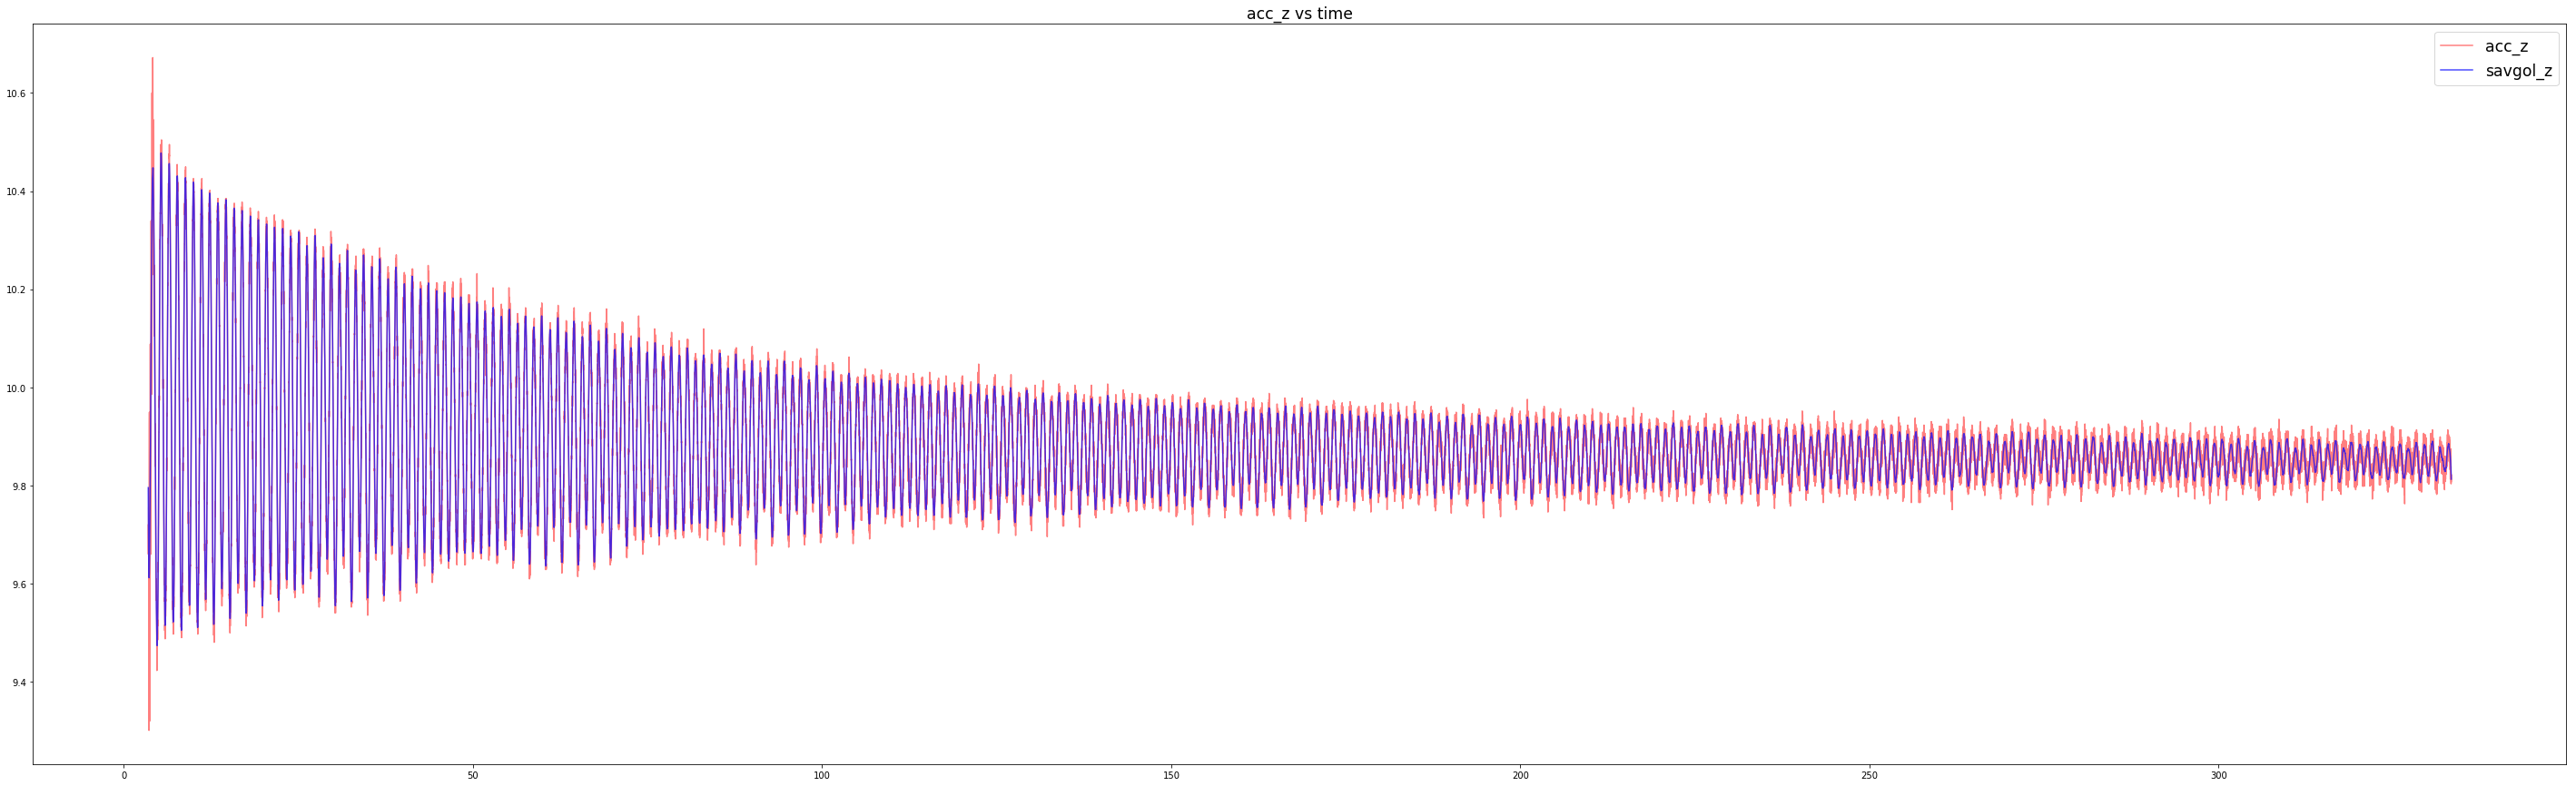

In [133]:
plt.figure(figsize=(50,15))
plt.title(label="acc_z vs time", fontsize="xx-large")
plt.plot(data['DOF time'], data['acc_z'], color = "red", alpha=0.5)
plt.plot(data['DOF time'], data['savgol_z'], color = "blue", alpha=0.7)
plt.legend(fontsize="xx-large")

# It is hard to tell whether our data is smoothed enough. Only way to tell is to apply our peak finder and see if it fails miserably. 

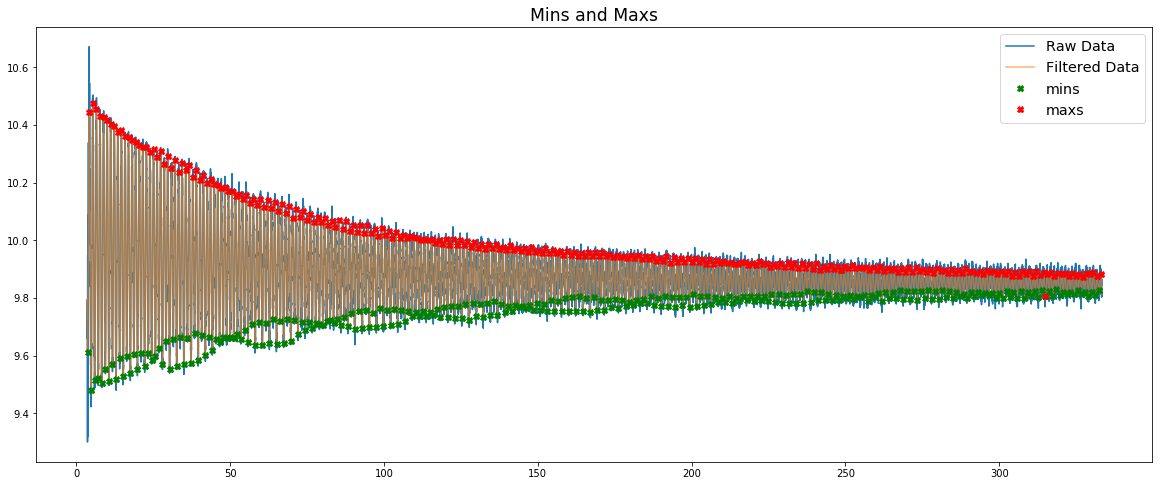

In [134]:
from scipy.signal import argrelextrema
from scipy.signal import find_peaks


dist_arr = data['savgol_z_2'].to_numpy()
mins = argrelextrema(dist_arr, np.less)[0].tolist()
maxs = argrelextrema(dist_arr, np.greater)[0].tolist()

min_times = []
min_distances = []

max_times = []
max_distances = []

for n in mins:
    min_distances.append(data['savgol_z_2'].iloc[n]) #retrieves distance at each local minimum's index
    min_times.append(data['DOF time'].iloc[n])

for n in maxs:
    max_distances.append(data['savgol_z_2'].iloc[n])
    max_times.append(data['DOF time'].iloc[n])




plt.figure(figsize=(20, 8))
plt.plot(data['DOF time'], data['acc_z'], label = "Raw Data")
plt.plot(data['DOF time'], data['savgol_z_2'], label='Filtered Data', alpha = 0.6)
plt.plot(min_times, min_distances, "X", color = "green", label="mins")
plt.plot(max_times, max_distances, "X", color = "red", label="maxs")
plt.title(label="Mins and Maxs", fontsize="xx-large")
plt.legend(fontsize="x-large")

# Okay not bad! Note that I am finding peaks of savgol_z_2 (doubly smoothed). 
### Also, I sliced a little off the beginning of the dataset. The noise here can cause inaccuracy with fitting
- From here, I think I can write a script that will clean up the peaks based on certain conditions
- Max times and min times should be spaced about 1.2 seconds apart. If any proceeding peak time is less than 1.2 seconds from the previous peak, we throw it away and treat it as an invalid peak

- We want to combine mins and max and SORT THEM BASED ON TIMES! this is our distilled data

In [139]:
for i in range(len(max_times)-1):      # REMOVING OVERCOUNTED MAX AND MIN TIMES. VERY IMPORTANT
    if max_times[i+1]-max_times[i]<1.0:
        max_times.remove(max_times[i+1])

for i in range(len(min_times)-1):      # REMOVING OVERCOUNTED MAX AND MIN TIMES. VERY IMPORTANT
    if min_times[i+1]-min_times[i]<1.0:
        min_times.remove(min_times[i+1])


period_sum = 0
period_sum_min = 0

for i in range(len(max_times)-1): 
    period_sum += max_times[i+1]-max_times[i]

for i in range(len(min_times)-1): 
    period_sum_min += min_times[i+1]-min_times[i]

average_period_1 = period_sum/(len(max_times)-1)
average_period_2 = period_sum_min/(len(min_times)-1)
average_period = (average_period_1 + average_period_2)
expected_period = 2*np.pi*np.sqrt(1.283/9.81)
print("Average period =", average_period, "s")
print("Expected period =", expected_period, "s")


Average period = 2.3196392126623318 s
Expected period = 2.2722635027055924 s


In [140]:
min_times.extend(max_times)       # COMBINE THE LISTS AND SORT THE TIMES AT WHICH PEAKS OCCUR
min_times.sort(key=float)
distilled_data = data[data['DOF time'].isin(min_times)]    # CREATE A DISTILLED DATAFRAME
distilled_data.head(5)

,TOF time,d,DOF time,acc_x,acc_y,acc_z,magn_x,magn_y,magn_z,gyr_x,gyr_y,gyr_z,savgol_z,savgol_z_2
312,3.053657,72.0,3.604373,0.509671,-2.277967,9.365508,-37.8,-60.6,-97.5,-5.898438,12.226562,-9.421875,9.611983,9.611983
367,3.647477,100.0,4.138266,2.132005,-2.103291,10.671989,-42.4,-62.8,-95.4,12.195312,-44.312500,-36.289062,10.440143,10.444176
431,4.294034,44.0,4.758590,2.031506,-1.981257,9.499506,-44.4,-66.1,-96.0,-5.953125,-2.046875,-18.710938,9.473738,9.479878
490,4.900417,84.0,5.331030,1.883151,-2.165504,10.463813,-36.1,-58.6,-96.1,-32.015625,33.367188,-0.695312,10.476794,10.477017
549,5.481252,45.0,5.902823,1.572084,-2.019542,9.518648,-29.5,-50.2,-96.2,-0.195312,5.695312,-11.148438,9.515738,9.516997


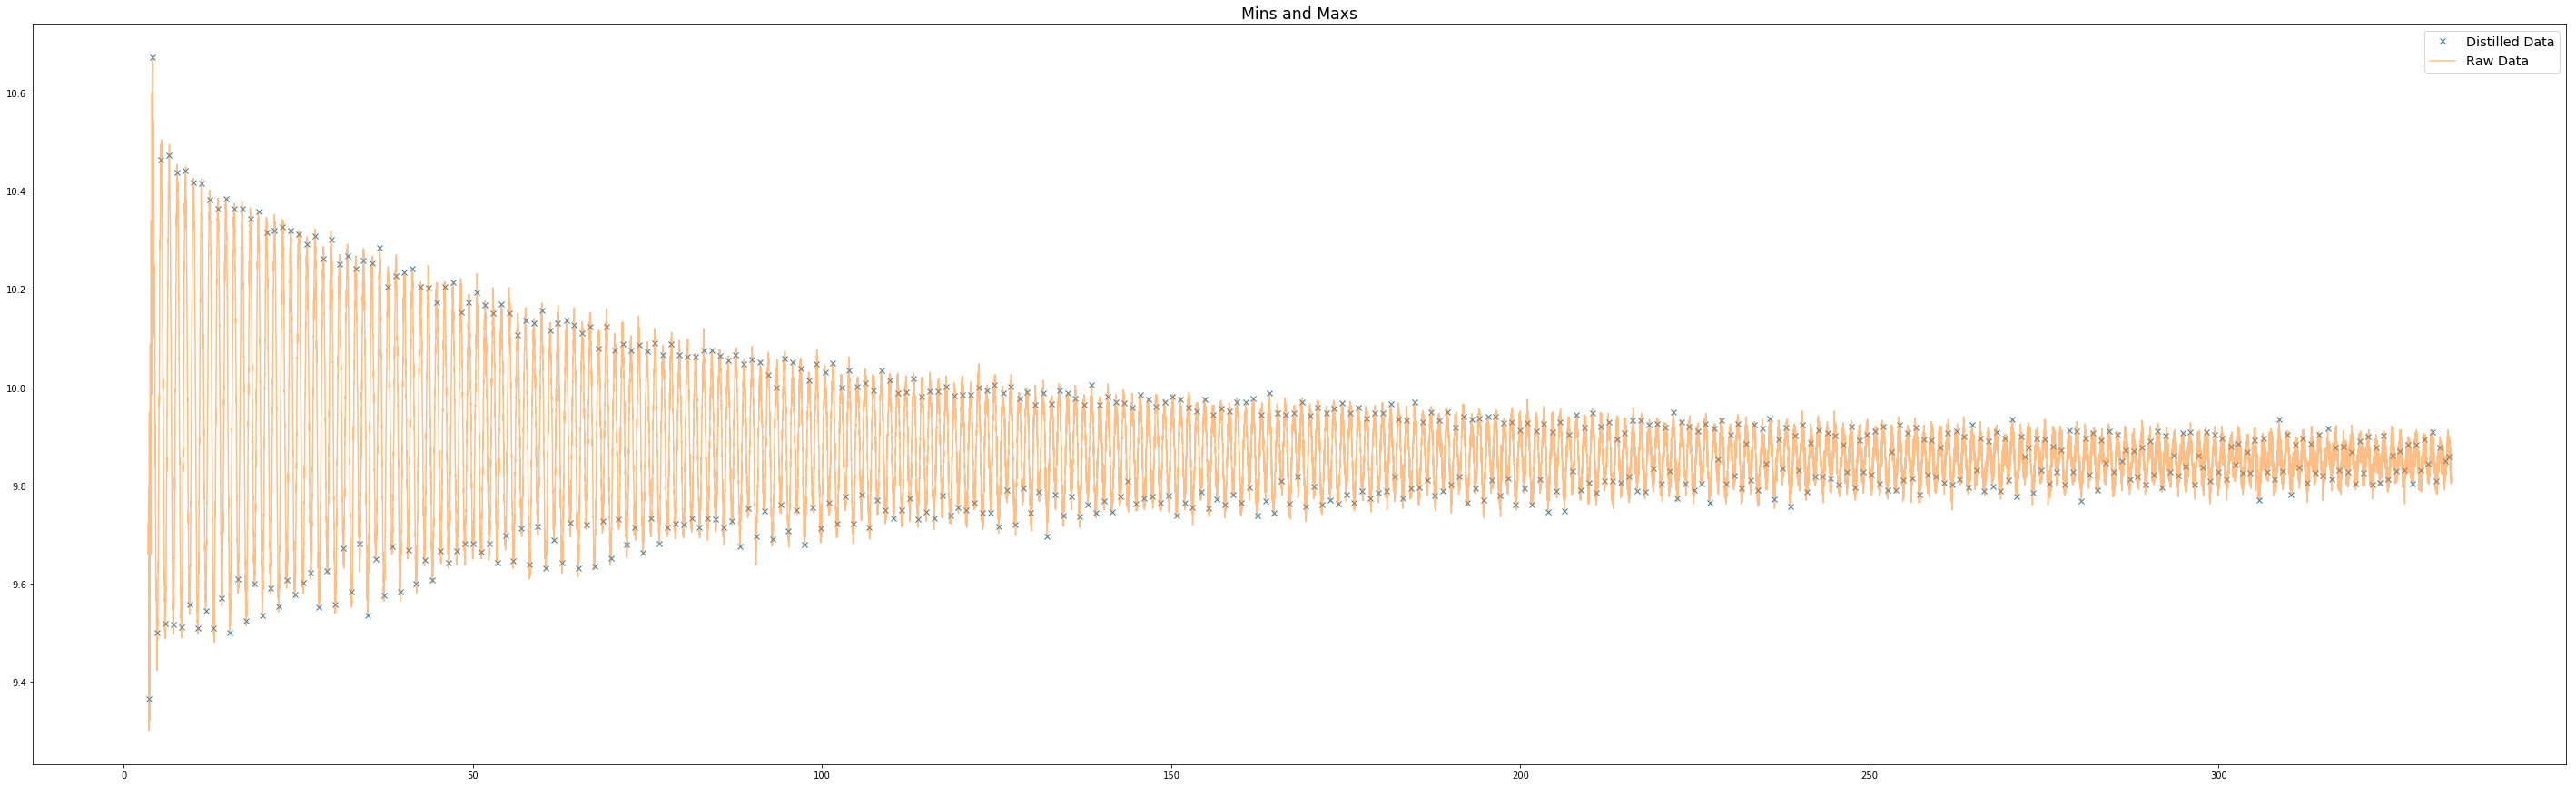

In [141]:
plt.figure(figsize=(50,15))
plt.plot(distilled_data['DOF time'], distilled_data['acc_z'], "x", label = "Distilled Data")
plt.plot(data['DOF time'], data['acc_z'], label='Raw Data', alpha = 0.5)
plt.title(label="Mins and Maxs", fontsize="xx-large")
plt.legend(fontsize="x-large")

# Simple Harmonic Solution (Small angle approx)
- O(t) = O * cos(wt + phi) , w = (g/L)^0.5 , L = 1.283

Best parameters for amp, g, phase, up:  [ 5.84804606e-03  9.82970255e+00 -8.44754887e-02  9.87851617e+00]
Std. of parameters:  [0.01047346 0.13411841 3.64330541 0.00741391]


g based on fit: 9.8297 +/- 0.1341184069010977
Period based on fit: 2.2699851
Average Period extracted from distilled data: 2.3196392
Expected Period: 2.2722635


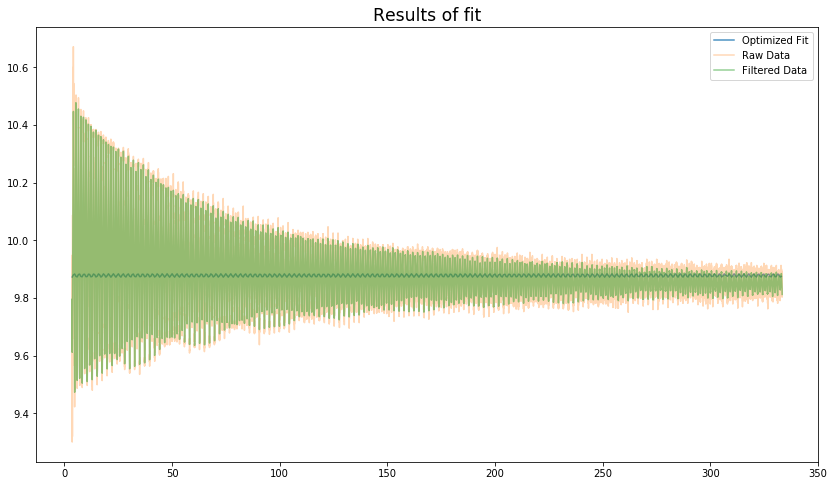

In [142]:
def small_angle(x, amp, g, phase, up):
    return amp*np.cos((np.sqrt(g/1.283)*x)+phase)+up


params, params_covariance = optimize.curve_fit(small_angle, distilled_data['DOF time'], distilled_data['acc_z'], 
                                                   p0=[50, 9.81, 1, 10],maxfev=5000) 

print("Best parameters for amp, g, phase, up: ", params)
print("Std. of parameters: ", np.sqrt(np.diag(params_covariance)))
print("\n")

period = 2*np.pi*np.sqrt(1.283/params[1])
print("g based on fit:", round(params[1],4), "+/-", np.sqrt(np.diag(params_covariance))[1])
print("Period based on fit:", round(period,7))
print("Average Period extracted from distilled data:", round(average_period,7))
print("Expected Period:", round(expected_period,7))



plt.figure(figsize=(14, 8))


plt.plot(distilled_data['DOF time'], small_angle(distilled_data['DOF time'], params[0], params[1], params[2], params[3]), label="Optimized Fit", alpha=0.8)
plt.plot(data['DOF time'], data['acc_z'], label='Raw Data', alpha = 0.3)
plt.plot(data['DOF time'], data['savgol_z'], label = "Filtered Data", alpha = 0.5)
plt.title("Results of fit", fontsize="xx-large")
plt.legend(loc='best')